In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from src.stewart_controller import Stewart_Platform
import warnings
import os

# How to calculate and plot a platform

[0.96678485 0.77703419 0.96678485 0.77703419 0.96678485 0.77703419]


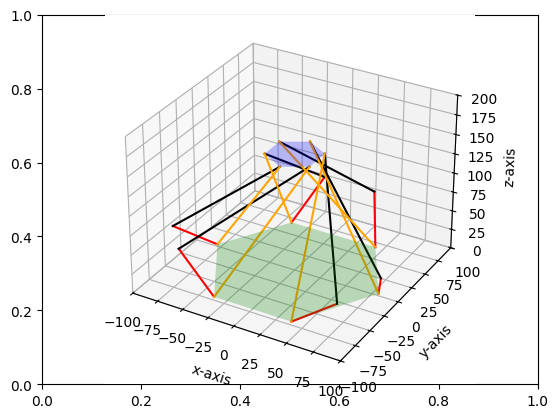

In [21]:
from src.stewart_controller import Stewart_Platform
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# To calculate angles, initiate object
# Stewart_Platform(r_B, r_P, lhl, ldl, Psi_B, Psi_P, ref_rotation)
r_B = 80
r_P = 25
lhl = 60
ldl = 150
psi_B = np.deg2rad(28)
psi_P = np.deg2rad(29)

platform = Stewart_Platform(r_B, r_P, lhl, ldl, psi_B, psi_P, 5*np.pi/6)

# platform.calculate(np.array[tx, ty, tz],np.array[rx, ry, rz])
servo_angles = platform.calculate( np.array([0,0,0]), np.array([0, 0, 1.57]) )
print(servo_angles)

# To Plot
#%matplotlib qt 
fig, ax = plt.subplots()
ax = platform.plot_platform()
plt.draw()

# Rod lengths and base and platform diameters variation  
The goal here is to try different length for the mechanism rods and different diameters for the base and the platform, in order to check if we can still check the following requirements:  
- +/- 3cm on Z translation (vertical)  
- +/- 60° yaw rotation of the platform  
- +/- 30° Roll and Pitch  

We want a compact mechanism that check these requirements. A small driving rod is also good to reduce the needed torque on the motors.

In [2]:
# Define the parameters for the Stewart platform
r_B_values = np.linspace(30, 100, 8)  # Variation between 3cm et 10cm (8 valeurs)
r_P = 25  # fix that value corresponding to the neck of Reachy Mini
lhl_values = np.linspace(20, 100, 9)  # between 2cm and 10cm
ldl_values = np.linspace(50, 300, 6)  # entre 5cm et 30cm
# Psi_B_values = np.linspace(0, 2 * np.pi, 12)  # 0 to 360° with 12 values
# Psi_P_values = np.linspace(0, 2 * np.pi, 12)  
Psi_B = 0.2269 # 13° in rad
Psi_P = 0.82 # 47° in rad

# Saving the valid designs
valid_designs = []

# Function to calculate angles with exception handling
def safe_calculate(platform, pos, rot):
    try:
        angles = platform.calculate(pos, rot)
        if np.any(np.isnan(angles)):
            return None
        return angles
    except Exception:
        return None

# Function to check if motor angles are within the specified range
def check_motor_angles(angles_rad):
    angles_deg = np.degrees(angles_rad)
    return np.all(np.abs(angles_deg) <= 110)



In [14]:
# Loop through all combinations
warnings.filterwarnings("ignore", category=RuntimeWarning)

for r_B in r_B_values:
    for lhl in lhl_values:
        for ldl in ldl_values:
            platform = Stewart_Platform(r_B, r_P, lhl, ldl, Psi_B, Psi_P, 5 * np.pi / 6)

            # Test scenarios
            test_cases = [
                (np.array([0, 0, 0]), np.array([0, 0, 0])), # center
                (np.array([0, 0, 30]), np.array([0, 0, 0])), # center + 30cm on Z
                (np.array([0, 0, -30]), np.array([0, 0, 0])), # center - 30cm on Z
                (np.array([0, 0, 30]), np.array([30 * np.pi / 180, 0, 0])), # +30° pitch
                (np.array([0, 0, 30]), np.array([-30 * np.pi / 180, 0, 0])), # -30° pitch
                (np.array([0, 0, 30]), np.array([0, 30 * np.pi / 180, 0])), # +30° roll
                (np.array([0, 0, 30]), np.array([0, -30 * np.pi / 180, 0])), # -30° roll
                (
                    np.array([0, 0, 30]),
                    np.array([0, 0, 60 * np.pi / 180]),
                ),  # +60° yaw
                (
                    np.array([0, 0, 30]),
                    np.array([0, 0, -60 * np.pi / 180]),
                ),  # -60° yaw
            ]

            all_ok = True
            for pos, rot in test_cases:
                angles = safe_calculate(platform, pos, rot)
                if angles is None or not check_motor_angles(angles):
                    all_ok = False
                    break

            if not all_ok:
                continue
            
            # Calculate the platform height
            height_base = np.mean(platform.L[2, :])  # moyenne des Z des points plateforme


            # Design valide
            valid_designs.append(
                {
                    "r_B": r_B,
                    "r_P": r_P,
                    "lhl": lhl,
                    "ldl": ldl,
                    "Psi_B": Psi_B,
                    "Psi_P": Psi_P,
                    "height_base": height_base,
                }
            )
print(f"Nombre de designs valides : {len(valid_designs)}")

Nombre de designs valides : 212


In [15]:
# Output folder
output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

# Base filename
base_filename = "valid_designs"
filename = os.path.join(output_folder, base_filename + ".json")

# Increment filename if it already exists
counter = 1
while os.path.exists(filename):
    filename = os.path.join(output_folder, f"{base_filename}_{counter}.json")
    counter += 1

# Save the JSON file
with open(filename, "w") as f:
    json.dump(valid_designs, f, indent=4)

print(f"Valid designs saved to '{filename}'.")

Valid designs saved to 'results/valid_designs.json'.


In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
from src.stewart_controller import Stewart_Platform

# Load valid designs
with open("results/valid_designs.json", "r") as f:
    designs = json.load(f)

# Display available designs
print(f"{len(designs)} valid designs loaded:\n")
for idx, design in enumerate(designs):
    print(
        f"[{idx}] r_B={design['r_B']}mm, r_P={design['r_P']}mm, "
        f"lhl={design['lhl']}mm, ldl={design['ldl']}mm, "
        f"Psi_B={np.degrees(design['Psi_B']):.1f}°, Psi_P={np.degrees(design['Psi_P']):.1f}°"
        f", height_base={design['height_base']:.1f}mm"
    )


212 valid designs loaded:

[0] r_B=30.0mm, r_P=25mm, lhl=50.0mm, ldl=200.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=236.1mm
[1] r_B=30.0mm, r_P=25mm, lhl=50.0mm, ldl=250.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=284.9mm
[2] r_B=30.0mm, r_P=25mm, lhl=50.0mm, ldl=300.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=334.1mm
[3] r_B=30.0mm, r_P=25mm, lhl=60.0mm, ldl=100.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=146.5mm
[4] r_B=30.0mm, r_P=25mm, lhl=60.0mm, ldl=150.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=191.5mm
[5] r_B=30.0mm, r_P=25mm, lhl=60.0mm, ldl=200.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=238.7mm
[6] r_B=30.0mm, r_P=25mm, lhl=60.0mm, ldl=250.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=287.1mm
[7] r_B=30.0mm, r_P=25mm, lhl=60.0mm, ldl=300.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=335.9mm
[8] r_B=30.0mm, r_P=25mm, lhl=70.0mm, ldl=100.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=152.0mm
[9] r_B=30.0mm, r_P=25mm, lhl=70.0mm, ldl=150.0mm, Psi_B=13.0°, Psi_P=47.0°, height_base=195.5mm
[10

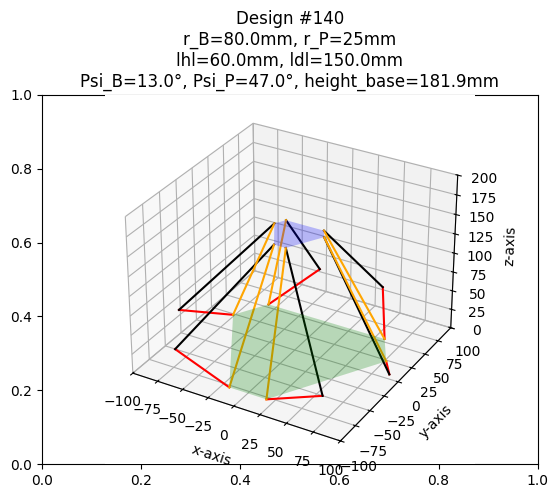

In [24]:
# Ask user to select a design
selection = int(input("\nEnter the number of the design to display: "))

# Get selected design
selected = designs[selection]

# Create the platform
platform = Stewart_Platform(
    selected["r_B"],
    selected["r_P"],
    selected["lhl"],
    selected["ldl"],
    selected["Psi_B"],
    selected["Psi_P"],
    5 * np.pi / 6
)

# Calculate neutral position
platform.calculate(np.array([0,0,0]), np.array([0,0,0]))

# Plot the platform
fig, ax = plt.subplots()
ax = platform.plot_platform()
ax.set_title(
    f"Design #{selection}\n"
    f"r_B={selected['r_B']}mm, r_P={selected['r_P']}mm\n"
    f"lhl={selected['lhl']}mm, ldl={selected['ldl']}mm\n"
    f"Psi_B={np.degrees(selected['Psi_B']):.1f}°, Psi_P={np.degrees(selected['Psi_P']):.1f}°"
    f", height_base={selected['height_base']:.1f}mm"
)
plt.show()

# Anchor Points Configuration  
The goal is to verify the impact of motor placement and actuator direction.  
Do we obtain more roll pitch, or is there less stability (more play)?  

⇒ Test on a “standard” platform that is not necessarily optimal. in different configurations and measure max RPY.  
Configurations to be tested:  

- Vertical | |
- Triangle pointing upward / \
- Triangle pointing downard \ /
- Parallel sideway \ \ or / /  

=> Choose config name in the cell below

In [ ]:
import numpy as np
from src.stewart_controller import Stewart_Platform
import matplotlib.pyplot as plt

# === configurations ===
configs = {
    "Vertical": {"Psi_b": 28, "Psi_p": 28},
    "Triangle_Up": {"Psi_b": 13, "Psi_p": 55},
    "Triangle_Down": {"Psi_b": 7, "Psi_p": 10},
    "Fine_Triangle_Down": {"Psi_b": 3, "Psi_p": 10},
}

# === Choose configuration ===
config_name = "Fine_Triangle_Down"  # <=== Modify here
params = configs[config_name]

# Convertir en radians
Psi_b = np.radians(params["Psi_b"])
Psi_p = np.radians(params["Psi_p"])

# --- Paramètres de la plateforme ---
R_b = 80
R_p = 25
lhl = 60
ldl = 150
# Psi_b = np.radians(28)
# Psi_p = np.radians(28)
ref_rotation = 5 * np.pi / 6

# Loop through all combinations
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Créer la plateforme ---
platform = Stewart_Platform(R_b, R_p, lhl, ldl, Psi_b, Psi_p, ref_rotation)

# --- motors limits - absolute degrees ---
motor_limit = 110

# --- Fonction safe calculate ---
def safe_calculate(pos, rot):
    try:
        angles = platform.calculate(pos, rot)
        if np.any(np.isnan(angles)):
            return None
        return np.degrees(angles)
    except:
        return None

# --- Find max translation Z ---
z_vals = np.arange(0, 200, 1)  # tester de 0 à +200 mm
max_z = 0
for z in z_vals:
    angles = safe_calculate([0,0,z], [0,0,0])
    if angles is None or np.any(np.abs(angles) > motor_limit):
        break
    max_z = z

# --- Find max Roll ---
roll_vals = np.radians(np.arange(0, 90, 1))
max_roll = 0
for r in roll_vals:
    angles = safe_calculate([0,0,30], [r,0,0])
    if angles is None or np.any(np.abs(angles) > motor_limit):
        break
    max_roll = np.degrees(r)

# --- Find max Pitch ---
pitch_vals = np.radians(np.arange(0, 90, 1))
max_pitch = 0
for p in pitch_vals:
    angles = safe_calculate([0,0,30], [0,p,0])
    if angles is None or np.any(np.abs(angles) > motor_limit):
        break
    max_pitch = np.degrees(p)

# --- Find max Yaw ---
yaw_vals = np.radians(np.arange(0, 90, 1))
max_yaw = 0
for y in yaw_vals:
    angles = safe_calculate([0,0,30], [0,0,y])
    if angles is None or np.any(np.abs(angles) > motor_limit):
        break
    max_yaw = np.degrees(y)

# --- Calculate stability (sensitivity) ---
# Measure delta motor for a small angle increment
small_angle = np.radians(1)  # 1° increment
angles_ref = safe_calculate([0,0,30], [0,0,0])

angles_roll_1 = safe_calculate([0,0,30], [small_angle,0,0])
angles_pitch_1 = safe_calculate([0,0,30], [0,small_angle,0])
angles_yaw_1 = safe_calculate([0,0,30], [0,0,small_angle])

if angles_ref is not None:
    delta_roll = np.mean(np.abs(angles_roll_1 - angles_ref)) if angles_roll_1 is not None else None
    delta_pitch = np.mean(np.abs(angles_pitch_1 - angles_ref)) if angles_pitch_1 is not None else None
    delta_yaw = np.mean(np.abs(angles_yaw_1 - angles_ref)) if angles_yaw_1 is not None else None
else:
    delta_roll = delta_pitch = delta_yaw = None

# --- Results ---
print(f"Max translation Z: {max_z:.1f} mm")
print(f"Max Roll: {max_roll:.1f}°")
print(f"Max Pitch: {max_pitch:.1f}°")
print(f"Max Yaw: {max_yaw:.1f}°")

print("\nStability (mean angular variation for 1° of rotation) :")
print(f"Δ motors for +1° Roll: {delta_roll:.2f}°")
print(f"Δ motors for +1° Pitch: {delta_pitch:.2f}°")
print(f"Δ motors for +1° Yaw: {delta_yaw:.2f}°")


Max translation Z: 47.0 mm
Max Roll: 41.0°
Max Pitch: 40.0°
Max Yaw: 68.0°

Stabilité (variation angulaire moyenne des moteurs pour +1° rotation) :
Δ moteurs pour +1° Roll: 0.34°
Δ moteurs pour +1° Pitch: 0.32°
Δ moteurs pour +1° Yaw: 0.12°


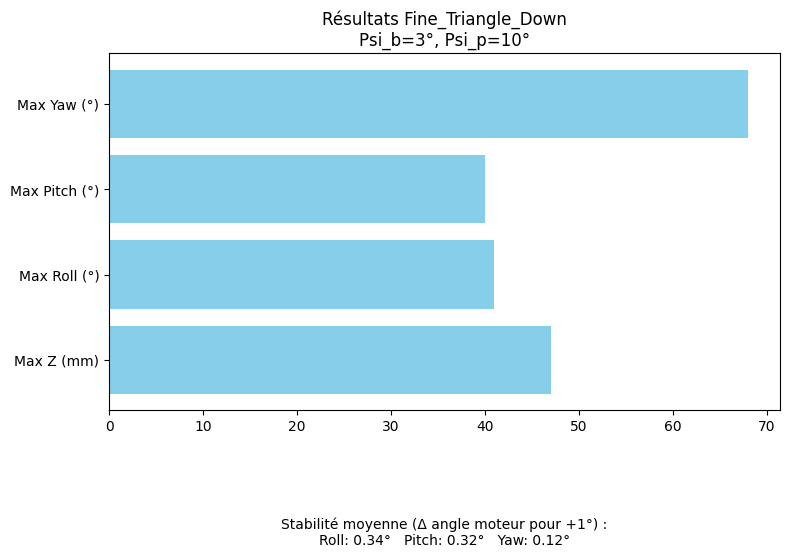

Résultats sauvegardés dans result_Fine_Triangle_Down.png


In [ ]:
# === Plot ===
fig, ax = plt.subplots(figsize=(8,6))

# Rods amplitudes
bars = ["Max Z (mm)", "Max Roll (°)", "Max Pitch (°)", "Max Yaw (°)"]
values = [max_z, max_roll, max_pitch, max_yaw]
ax.barh(bars, values, color='skyblue')

# Add text for sensitivity
sens_text = (f"Stability (mean) (Δ angle motor for +1°) :\n"
             f"Roll: {delta_roll:.2f}°   Pitch: {delta_pitch:.2f}°   Yaw: {delta_yaw:.2f}°")

ax.set_title(f"Results {config_name}\nPsi_b={params['Psi_b']}°, Psi_p={params['Psi_p']}°", fontsize=12)
ax.text(0.5, -0.3, sens_text, transform=ax.transAxes, fontsize=10, ha='center', va='top')

plt.tight_layout()
png_filename = f"result_{config_name.replace(' ','_')}.png"
plt.savefig(png_filename, dpi=300)
plt.show()

print(f"Results saved as {png_filename}")